In [1]:
import numpy as np
from shapely import Polygon, LineString
from shapely.ops import unary_union
import utm
import ast

In [2]:
def from_latlon(latitude, longitude):
    """
    convert lat, lon to (x, y) coordinates (in meters)
    :param latitude:  list or np.array (shape: (n,))
    :param longitude: list or np.array (shape: (n,))
    :return: np.array of (x, y) coordinates (shape: (n, 2))
    """
    xy = np.array([
        utm.from_latlon(lat, lon)[:2] for lat, lon in zip(latitude, longitude)
    ])
    return xy



def get_working_lines(track_xy : np.array, inwork : list):
    """
    get list of subtracks where tool is working
    :param track_xy: np.array of (x, y) coordinates (shape: (n, 2))
    :param inwork: list or np.array of tool-is-working flags (shape: (n,))
    :return: list of subtracks, where the tool is working
    """
    working_lines = []
    cur_line = []
    for i, flag in enumerate(inwork):
        if flag == 1:
            cur_line.append(track_xy[i])
            continue
        working_lines.append(cur_line)
        cur_line = []
        
    working_lines.append(cur_line)
    return working_lines



def get_working_tracks(working_lines : list, tool_width : float):
    """
    get union of track polygons where tool is working
    :param working_lines: list of subtracks where tool is working
    :param tool_width: tool width (in meters)
    :return: union of track polygons where tool is working
    """
    working_tracks = []
    for line in working_lines:
        if len(line) > 1:
            cur_track = LineString(line).buffer(tool_width, cap_style='flat')
            working_tracks.append(cur_track)
    return unary_union(working_tracks)



def get_field_xy(field_bounds : dict):
    """
    convert GPS bounds of field into (x, y) coordinates (in meters)
    :param field_bounds: dictionary with inner and outer GPS bounds
    :return: dictionary with inner and outer (x, y) bounds
    """
    outer = np.array(field_bounds['outer']).T
    outer_xy = from_latlon(outer[0], outer[1])
    
    inner = [np.array(hole).T for hole in field_bounds['inner']]
    inner_xy = [from_latlon(hole[0], hole[1]) for hole in inner]
    
    field_bounds_xy = {
        'outer': outer_xy,
        'inner': inner_xy
    }
    return field_bounds_xy

In [3]:
def get_area(
    track_lat : list,
    track_lon : list,
    field_bounds : dict,
    tool_width : float,
    inwork : list
):
    """
    calculate processed field area
    :param track_lat: list or np.array (shape: (n,))
    :param track_lon: list or np.array (shape: (n,))
    :param field_bounds: dictionary with outer and inner GPS field bounds
    :param tool_width: width of the tool (in meters)
    :param inwork: list or np.array of tool-is-working flags (shape: (n,))
    :return: area of the processed field (in square meters)
    """
    # convert GPS coordinates of the track
    track_xy = from_latlon(track_lat, track_lon)
    # get subtracks where tool is working
    working_lines = get_working_lines(track_xy, inwork)
    # get polygon of subtracks where tool is working
    working_tracks = get_working_tracks(working_lines, tool_width/2)

    # convert GPS coordinates of field bounds and create field polygon
    field_bounds_xy = get_field_xy(field_bounds)
    field_polygon = Polygon(
        shell=field_bounds_xy['outer'], 
        holes=field_bounds_xy['inner']
    )

    # get total processed area
    processed_field = field_polygon.intersection(working_tracks)
    total_area = processed_field.area
    return field_polygon, processed_field, total_area

## New area and distance calculator

In [4]:
def get_subfields_xy(field_bounds: list):
    subfields = [np.array(subfield).T for subfield in field_bounds]
    bounds_xy = [from_latlon(field[1], field[0]) for field in subfields]
    return bounds_xy

In [5]:
def get_area_and_distance(
    tool_width : float,
    time : list,
    track_lat : list,
    track_lon : list,
    path_distance : list,
    field_processed : list,
    field_bounds : list
):
    """
    calculate path distance and processed field area
    :param tool_width: width of the tool (in meters)
    :param track_lat: list or np.array (shape: (n,))
    :param track_lon: list or np.array (shape: (n,))
    :param path_distance: list of pre-calculated path distances (shape: (m,))
    :param field_processed: list of pre-calculated processed area (shape: (m,))
    :param field_bounds: list of GPS subfields bounds
    :return: dictionary with calculated processed area and path distance
    """
    # convert GPS coordinates of the track
    track_xy = from_latlon(track_lat, track_lon)
    # convert GPS coordinates of the field bounds and create field polygon
    subfields_xy = get_subfields_xy(field_bounds)
    field_polygon = unary_union([Polygon(subfield) for subfield in subfields_xy])
    # calculate distance and area and add them to the lists
    for i in range(len(field_processed), len(time)):
        track = LineString(track_xy[:i])
        path_distance.append(track.length)
        
        buffered_track = track.buffer(tool_width/2)
        processed_step = field_polygon.intersection(buffered_track)
        field_processed.append(processed_step.area)
        
    # create dictionary with output
    area_calc = {
        'tool_width': tool_width,
        'time': time,
        'lat': track_lat,
        'long': track_lon,
        'path_distance': path_distance,
        'field_processed': field_processed
    }

    return area_calc

In [6]:
def get_bounds_from_string(field_bounds_str : str):
    if field_bounds_str[:4] == '[[[[':
        field_bounds_str = field_bounds_str.replace('[[[', '[[').replace(']]]', ']]')
    field_bounds = ast.literal_eval(field_bounds_str) 
    return field_bounds

In [7]:
def update_area_calc(area_calc : dict, field_bounds_str : str):
    field_bounds = get_bounds_from_string(field_bounds_str)
    area_calc = get_area_and_distance(
        tool_width=area_calc['tool_width'],
        time=area_calc['time'],
        track_lat=area_calc['lat'],
        track_lon=area_calc['long'],
        path_distance=area_calc['path_distance'],
        field_processed=area_calc['field_processed'],
        field_bounds=field_bounds
    )
    return area_calc

## Test of previous area calculator

In [8]:
from tester import latitude, longitude

In [9]:
get_area_and_distance(
    tool_width =0,
    time=[],
    track_lat=[],
    track_lon=[],
    path_distance=[],
    field_processed=[],
    field_bounds=[]
)

{'tool_width': 0,
 'time': [],
 'lat': [],
 'long': [],
 'path_distance': [],
 'field_processed': []}

In [10]:
bounds = {
    'outer': [
        [49.439438, 24.507683],
        [49.436947, 24.506222],
        [49.433942, 24.506459],
        [49.430500, 24.508602],
        [49.427555, 24.508149],
        [49.427100, 24.510990],
        [49.439442, 24.514119]
    ],
    'inner': [
        [
            [49.435614, 24.507944],
            [49.434007, 24.507985],
            [49.434596, 24.509384],
            [49.435667, 24.509220]
        ],
        [
            [49.432374, 24.508273],
            [49.431571, 24.508520],
            [49.431732, 24.509590],
            [49.432454, 24.509343]
        ]
    ]
}

In [11]:
%%time
# test 1
field, track, area = get_area(
    track_lat=latitude,
    track_lon=longitude,
    field_bounds=bounds,
    tool_width=10,
    inwork=np.ones(len(latitude))
)
area

CPU times: user 45.6 ms, sys: 4.41 ms, total: 50 ms
Wall time: 49.1 ms


12213.660297783515

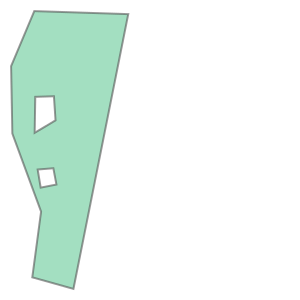

In [12]:
field

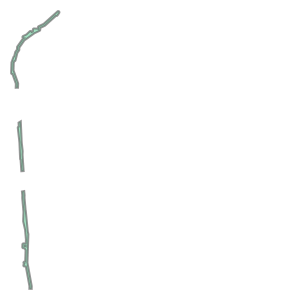

In [13]:
track

In [14]:
%%time
# test 2 => two points at distance nearly 500 meters from each other
latitude = [49.434680, 49.430187] 
longitude = [24.508728, 24.509285]   
bounds['inner'] = []  # field without holes

field, track, area = get_area(
    track_lat=latitude,
    track_lon=longitude,
    field_bounds=bounds,
    tool_width=10,
    inwork=np.ones(len(latitude))
)
area

CPU times: user 4.12 ms, sys: 1.06 ms, total: 5.18 ms
Wall time: 4.09 ms


5013.339876624908

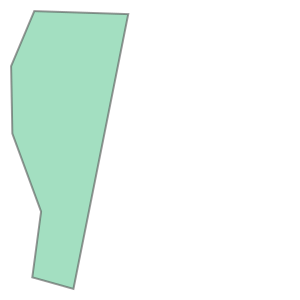

In [15]:
field

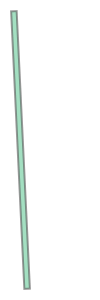

In [16]:
track